In [ ]:
!pip install pyEDFlib

     |████████████████████████████████| 1.2MB 4.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.20-cp36-cp36m-linux_x86_64.whl size=928478 sha256=11657ead08023bbc5e2452a48ce4c4abf7a636391a9f30516ea43c991097fc99
  Stored in directory: /root/.cache/pip/wheels/0d/be/b5/574f8b99ad9ac2ecf78e0c5271040b5aff999febfe655b97a4
Successfully built pyEDFlib


In [ ]:
import pandas as pd
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [100,50]

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
  
import numpy as np
import scipy.interpolate
from scipy import signal
from matplotlib import patches
import matplotlib.pyplot as plt

def get_psds(data, fs=128, f_range=[0.5, 30]):
    '''
    Calculate signal power using Welch method.
    Input: data- mxn matrix (m: number of channels, n: samples of signals)
           fs- Sampling frequency (default 128Hz)
           f_range- Frequency range (default 0.5Hz to 30Hz)
    Output: Power values and PSD values
    '''
    powers = []
    psds = list()
    for sig in data:
        freq, psd = signal.welch(sig, fs)
        idx = np.logical_and(freq >= f_range[0], freq <= f_range[1])
        powers = np.append(powers, sum(psd[idx]))
        psds.append(psd[idx])
    
    return powers, psds

def plot_topomap(data, ax, fig, draw_cbar=True):
    '''
    Plot topographic plot of EEG data. This specialy design for Emotiv 14 electrode data. 
    This can be change for any other arrangement by changing ch_pos (channel position array)
    Input: data- 1D array 14 data values
           ax- Matplotlib subplot object to be plotted every thing
           fig- Matplot lib figure object to draw colormap
           draw_cbar- Visualize color bar in the plot
    '''
    N = 300            
    xy_center = [2,2]  
    radius = 2 

    # AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
    ch_pos = [[1,4],[0.1,3], [1.5,3.5], [0.5,2.5], 
             [-0.1,2], [0.4,0.4], [1.5,0], [2.5,0], 
             [3.6,0.4], [4.1,2], [3.5,2.5], [2.5,3.5], 
             [3.9,3], [3,4]]
    x,y = [],[]
    for i in ch_pos:
        x.append(i[0])
        y.append(i[1])

    xi = np.linspace(-2, 6, N)
    yi = np.linspace(-2, 6, N)
    zi = scipy.interpolate.griddata((x, y), data, (xi[None,:], yi[:,None]), method='cubic')

    dr = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
            if (r - dr/2) > radius:
                zi[j,i] = "nan"
    
    dist = ax.contourf(xi, yi, zi, 60, cmap = plt.get_cmap('coolwarm'), zorder = 1)
    ax.contour(xi, yi, zi, 15, linewidths = 0.5,colors = "grey", zorder = 2)
    
    if draw_cbar:
        cbar = fig.colorbar(dist, ax=ax, format='%.1e')
        cbar.ax.tick_params(labelsize=8)

    ax.scatter(x, y, marker = 'o', c = 'b', s = 15, zorder = 3)
    circle = patches.Circle(xy = xy_center, radius = radius, edgecolor = "k", facecolor = "none", zorder=4)
    ax.add_patch(circle)

    for loc, spine in ax.spines.items():
        spine.set_linewidth(0)
    
    ax.set_xticks([])
    ax.set_yticks([])

    circle = patches.Ellipse(xy = [0,2], width = 0.4, height = 1.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
    ax.add_patch(circle)
    circle = patches.Ellipse(xy = [4,2], width = 0.4, height = 1.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
    ax.add_patch(circle)
    
    xy = [[1.6,3.6], [2,4.3],[2.4,3.6]]
    polygon = patches.Polygon(xy = xy, edgecolor = "k", facecolor = "w", zorder = 0)
    ax.add_patch(polygon) 
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)

    return ax




In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import time

In [ ]:
signals, signal_headers, header = highlevel.read_edf('/gdrive/MyDrive/Colab Notebooks/data_test/S001E01.edf')

Reading Channels: 100%|██████████| 14/14 [00:00<00:00, 353.69it/s]


In [ ]:
df = pd.DataFrame(signals)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46040,46041,46042,46043,46044,46045,46046,46047,46048,46049,46050,46051,46052,46053,46054,46055,46056,46057,46058,46059,46060,46061,46062,46063,46064,46065,46066,46067,46068,46069,46070,46071,46072,46073,46074,46075,46076,46077,46078,46079
0,-60.777768,-56.748166,-50.032164,-42.902870,-37.736714,-35.153637,-33.603790,-31.640651,-28.540958,-24.408033,-21.824955,-21.308340,-23.374802,-24.408033,-22.858186,-17.795354,-10.046121,-3.433442,-0.850364,-2.916826,-7.463043,-10.562736,-7.979659,-0.333749,8.965331,16.094626,19.710935,20.744166,22.294013,24.773767,26.840229,27.356845,25.806998,22.294013,20.227550,20.744166,24.773767,30.456538,33.556231,33.039616,...,-84.955375,-81.339067,-76.172911,-70.076848,-63.360846,-57.781398,-53.648473,-52.098627,-54.165089,-58.298013,-63.360846,-68.527001,-74.106449,-79.272604,-83.405529,-85.471991,-85.471991,-83.922144,-81.339067,-78.755989,-76.172911,-74.106449,-73.176541,-73.693156,-75.139680,-77.206142,-78.239373,-76.689527,-74.106449,-71.626694,-69.560232,-70.076848,-71.626694,-73.693156,-75.656296,-77.206142,-78.239373,-80.305836,-82.888913,-86.505222
1,0.865049,2.367500,2.367500,0.865049,-1.710582,-2.712216,-2.211399,-0.708948,-0.208131,-0.708948,-1.710582,-2.211399,-2.211399,-1.710582,-2.712216,-2.712216,-1.209765,2.367500,4.442313,1.866683,-5.287847,-12.513922,-15.590370,-11.440742,-3.284579,5.443947,11.096026,12.097660,10.094392,7.017944,3.941496,2.367500,1.866683,2.367500,3.941496,5.443947,5.944765,4.442313,-0.208131,-6.361026,...,99.812193,99.812193,100.813828,103.890275,109.542354,115.695249,120.846511,121.848145,119.844876,115.194432,109.542354,101.887007,92.657664,83.929138,77.776242,76.774608,79.278693,82.927504,83.929138,84.429955,86.003951,90.082033,93.659298,95.734112,94.160115,91.083667,90.082033,91.584484,94.160115,97.236563,98.309742,96.735746,94.660932,92.657664,91.584484,92.156847,93.659298,94.160115,93.158481,89.581216
2,-10.819863,-10.819863,-8.729611,-5.146321,-2.085595,0.452569,2.542821,3.513295,3.065384,-0.069995,-4.175847,-7.236574,-7.759137,-7.236574,-5.668884,-4.698410,-2.608158,-1.040469,-0.069995,-1.040469,-3.653284,-5.668884,-6.191447,-3.653284,-0.069995,3.065384,4.558421,4.558421,4.558421,5.603547,6.648673,7.096585,6.126110,5.080984,4.035858,3.513295,3.513295,3.513295,4.035858,4.035858,...,17.921105,20.459268,24.565121,29.716100,36.360116,43.004132,48.155111,49.722800,47.632547,45.094384,42.481569,40.988531,38.450368,34.344515,30.238663,26.655373,24.565121,24.042558,25.610247,27.625848,28.148411,27.625848,26.132810,25.087684,26.132810,28.148411,30.238663,31.731700,33.299389,34.344515,35.314990,35.314990,34.792427,33.299389,31.731700,31.209137,31.731700,32.776826,32.776826,30.686574
3,29.661179,28.570277,27.043013,24.970298,23.443035,23.006674,22.461222,21.915771,20.388507,18.315792,15.806717,12.206738,9.588572,7.079496,4.461330,2.497705,0.424990,-1.102273,-1.647725,-2.193176,-3.174988,-5.247703,-7.320418,-8.847682,-10.374945,-10.374945,-7.756779,-4.265891,-1.647725,-1.647725,-4.702252,-8.302230,-9.829494,-9.393133,-8.302230,-8.302230,-8.847682,-9.829494,-10.920396,-13.429472,...,123.478800,122.496988,121.406085,121.951537,124.460613,126.096967,125.006064,121.406085,118.897010,119.878822,121.951537,122.933349,120.424273,116.824295,116.278843,117.806107,120.424273,120.969724,119.878822,118.897010,118.897010,118.897010,118.351558,118.351558,119.333371,120.424273,119.878822,116.824295,113.769767,113.769767,116.278843,119.333371,120.424273,119.878822,119.333371,120.424273,120.969724,119.878822,117.806107,117.369746
4,0.353290,1.913312,1.406305,-0.660725,-2.181747,-2.181747,0.899298,4.487350,7.022386,6.515379,3.941342,0.353290,-2.181747,-2.181747,-0.660725,1.406305,2.927327,2.927327,1.406305,-1.167732,-3.234762,-4.248777,-4.755784,-4.755784,-5.262791,-5.262791,-2.727755,2.927327,8.075402,9.089416,4.487350,-3.234762,-8.850843,-7.836829,-0.660725,7.022386,10

In [ ]:
pwrs, _ = get_psds(signals)

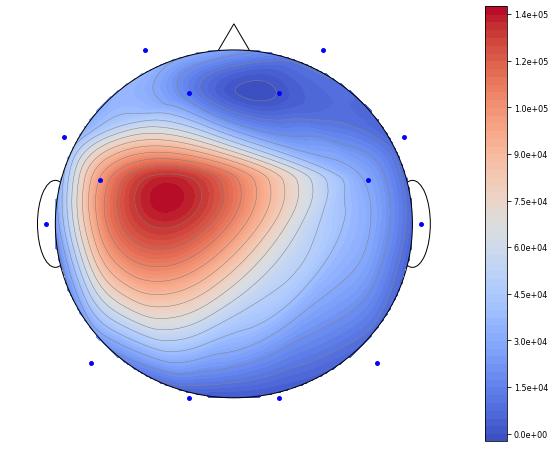

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_topomap(pwrs, ax, fig)
plt.show()

In [ ]:
df_headers = pd.DataFrame(signal_headers)
df_headers.head()

,label,dimension,sample_rate,physical_max,physical_min,digital_max,digital_min,prefilter,transducer
0,AF3,uV,256,3465.33,-3305.950,32767,-32768,LP: NaN Hz; HP: NaN Hz; Notch: NaN,
1,F7,uV,256,3724.44,-964.281,32767,-32768,LP: NaN Hz; HP: NaN Hz; Notch: NaN,
2,F3,uV,256,3557.39,-1334.920,32767,-32768,LP: NaN Hz; HP: NaN Hz; Notch: NaN,
3,FC5,uV,256,3725.53,-3423.700,32767,-32768,LP: NaN Hz; HP: NaN Hz; Notch: NaN,
4,T7,uV,256,2052.68,-503.222,32767,-32768,LP: NaN Hz; HP: NaN Hz; Notch: NaN,


In [ ]:
def eeg_plotter_multichannel(eeg_data, data_headers):
  j=0
  fig = plt.figure()
  fig.set_size_inches(20, 30)

  for r in range(0,13):
    #Construct approx images
    plt.style.use('dark_background')
    plt.subplot(13,1,j+1)
    plt.plot(eeg_data.iloc[j])
    plt.xlabel('time(s)')
    plt.ylabel('EEG values')
    plt.title('Channel'+data_headers['label'][j])
    j+=1
  plt.show()

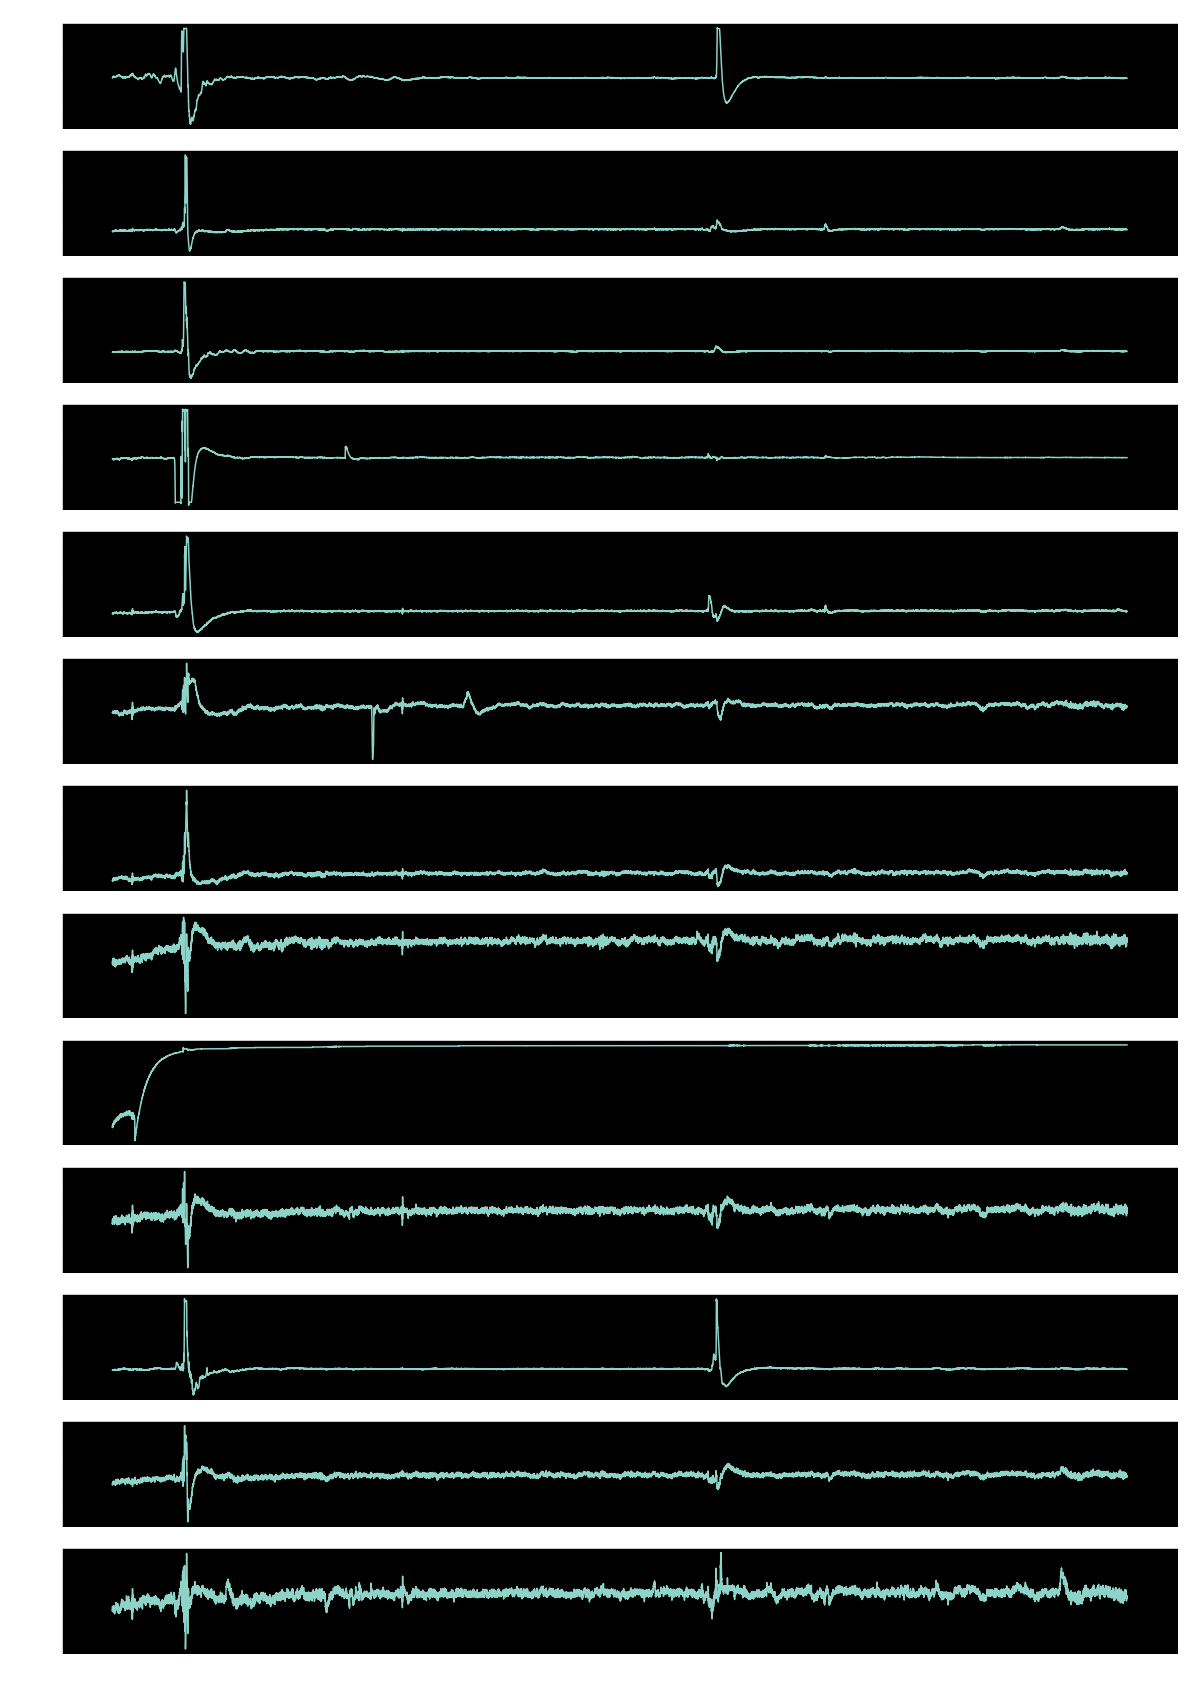

In [ ]:
eeg_plotter_multichannel(df,df_headers)

In [ ]:
channel_selected = input()

P8


Text(0, 0.5, 'EEG Data')

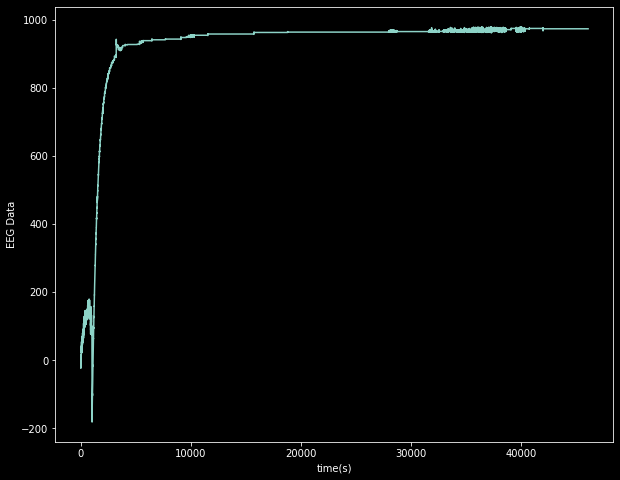

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#channel_selected = 'AF3'
id = df_headers.index[df_headers['label'] == channel_selected].tolist()[0]
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.plot(df.iloc[id])
plt.xlabel('time(s)')
plt.ylabel('EEG Data')

In [ ]:
print(df.iloc[id].to_numpy())

[-17.55878669 -23.20773225 -22.69419174 ... 973.20251394 973.20251394
 973.20251394]


In [ ]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
fs = 256.0
lowcut = 4.0
highcut = 13.0

y = butter_bandpass_filter(df.iloc[id].to_numpy(), lowcut, highcut, fs, order=6)

Text(0, 0.5, 'EEG Data')

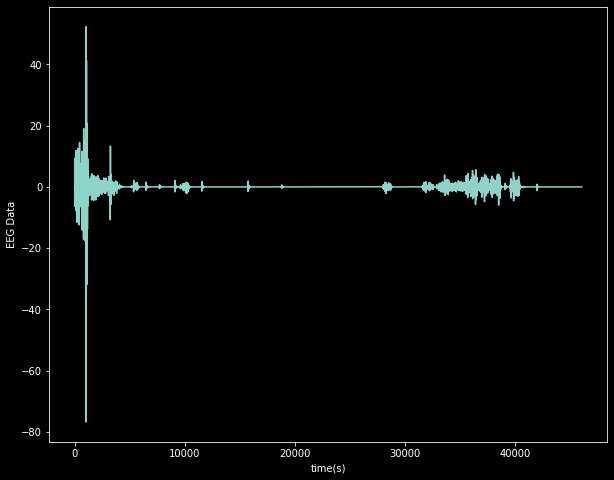

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.plot()
plt.xlabel('time(s)')
plt.ylabel('EEG Data')

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df.iloc[id], df.iloc[id+3])
print(corr)

0.3500469202533822


In [ ]:
import scipy.stats
entropy = scipy.stats.entropy(df.iloc[id].value_counts())
print(entropy)

3.4985017767267212


(array([1.50052301e+05, 7.59104264e+04, 1.08919407e+00, 2.53557396e-01,
        1.23198959e-01, 8.52232572e-02, 8.77626243e-02, 5.81563337e-02,
        3.35776698e-02, 3.12963598e-02, 3.70944102e-02, 2.97100035e-02,
        3.70808866e-02, 3.25292897e-02, 2.65672925e-02, 3.18784378e-02,
        3.05937545e-02, 2.74220875e-02, 2.54478699e-02, 2.59765748e-02,
        1.21717219e-02, 7.40638385e-03, 1.33456602e-02, 1.65213044e-02,
        2.02354739e-02, 1.55502916e-02, 1.00196225e-02, 1.39097698e-02,
        1.22621716e-02, 1.30589888e-02, 1.34011432e-02, 2.27109731e-02,
        2.62884768e-02, 2.22931306e-02, 1.25625204e-02, 9.83078619e-03,
        1.14302492e-02, 8.00291872e-03, 8.44911571e-03, 1.02633546e-02,
        7.74754310e-03, 1.15751775e-02, 1.95164778e-02, 1.73574174e-02,
        1.04387893e-02, 7.89952847e-03, 6.23373187e-03, 3.27635471e-03,
        1.39772939e-03, 3.90964498e-04, 2.44693364e-05, 2.18121850e-04,
        4.67905786e-04, 4.76806331e-04, 3.93997330e-04, 2.342155

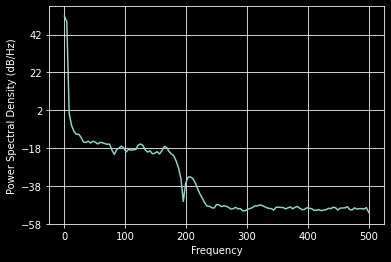

In [ ]:
plt.psd(df.iloc[id], 256, 1 / 0.001) 

(array([  390.,   737.,    80.,    93.,   274.,   215.,   345.,   969.,
        42862.]),
 array([   0,  100,  200,  300,  400,  600,  700,  800,  900, 1000]),
 <a list of 9 Patch objects>)

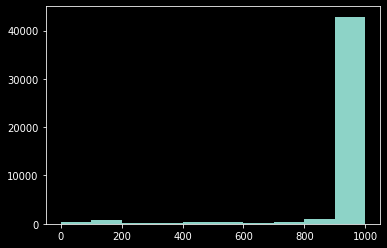

In [ ]:
plt.hist(df.iloc[id], bins = [0, 100, 200,300,400,600,700,800,900,1000])

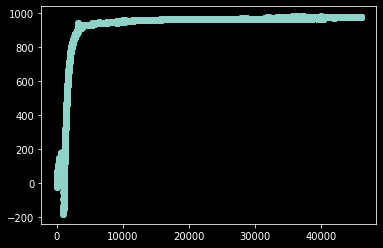

In [ ]:
plt.scatter(np.arange(0,len(df.iloc[id])),df.iloc[id])